In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
import pandas as pd 

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2

import warnings
warnings.filterwarnings("ignore")

# Описание задачи

Дан датасет real_estate_data, содержащий информацию об уровне преступности на душу насления в пригородах Бостона, а также общую информацию о стоимости жилья с учетом различных социальных факторов. 

Необходимо создать модель, лучше всего предсказывающую уровень преступности по остальным параметрам 

# Загрузка, первичная обработка датасета

In [3]:
# датасет вначале загружаем на гугл драйв real_estate_data.csv
# подгружаем файловую систему драйва в колаб
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [93]:
# загружаем датасет в колабе
all_data = pd.read_csv('/content/drive/My Drive/real_estate_data.csv')
# просмотрим первые 5 записей
all_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [94]:
# посмотрим информацию о датасете
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     511 non-null    float64
 1   ZN       511 non-null    float64
 2   INDUS    511 non-null    float64
 3   CHAS     511 non-null    int64  
 4   NOX      511 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      511 non-null    float64
 7   DIS      511 non-null    float64
 8   RAD      511 non-null    int64  
 9   TAX      511 non-null    int64  
 10  PTRATIO  511 non-null    float64
 11  B        511 non-null    float64
 12  LSTAT    511 non-null    float64
 13  MEDV     511 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 56.0 KB


**Описание колонок:**

*   CRIM - уровень преступности на душу населения
*   ZN - доля коммерческой собственности
*   INDUS - доля не розничного бизнеса
*   CHAS - фиктивная переменная Charles River (= 1, если участок граничит с  рекой; 0 в противном случае)
*   NOX - концентрация оксидов азота
*   RM - среднее количество комнат в доме
*   AGE - доля жилья, построенного до 1940 г.
*   DIS - взвешенные расстояния до пяти Бостонских центров занятости
*   RAD - индекс доступности радиальных магистралей
*   TAX - полная ставка налога на имущество за 10 000 долларов США
*   PTRATIO - количество учеников на одного учителя 
*   B - 1000(Bk - 0.63)^2 где Bk доля темнокожего населения
*   LSTAT - доля населения с низким социальным статусом
*   MEDV - средняя стоимость домов, занимаемых владельцами, в тысячах долларов

Колонка RM содержит 5 пропущенных записей




In [95]:
# заполним отсутсвующие записи средним значением по колонке
all_data.RM = all_data.RM.fillna(all_data.RM.mean())
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     511 non-null    float64
 1   ZN       511 non-null    float64
 2   INDUS    511 non-null    float64
 3   CHAS     511 non-null    int64  
 4   NOX      511 non-null    float64
 5   RM       511 non-null    float64
 6   AGE      511 non-null    float64
 7   DIS      511 non-null    float64
 8   RAD      511 non-null    int64  
 9   TAX      511 non-null    int64  
 10  PTRATIO  511 non-null    float64
 11  B        511 non-null    float64
 12  LSTAT    511 non-null    float64
 13  MEDV     511 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 56.0 KB


In [96]:
# поделим датасет на фичи и метки
all_df=all_data.drop(columns='CRIM')
all_y=all_data['CRIM']
# разобъём датасет на обучающую и тестовую выборку
train_df, test_df, y_train, y_test = train_test_split(all_df, all_y, test_size=0.21, random_state=0)

print(train_df.shape)

(403, 13)


# Разведочный анализ данных

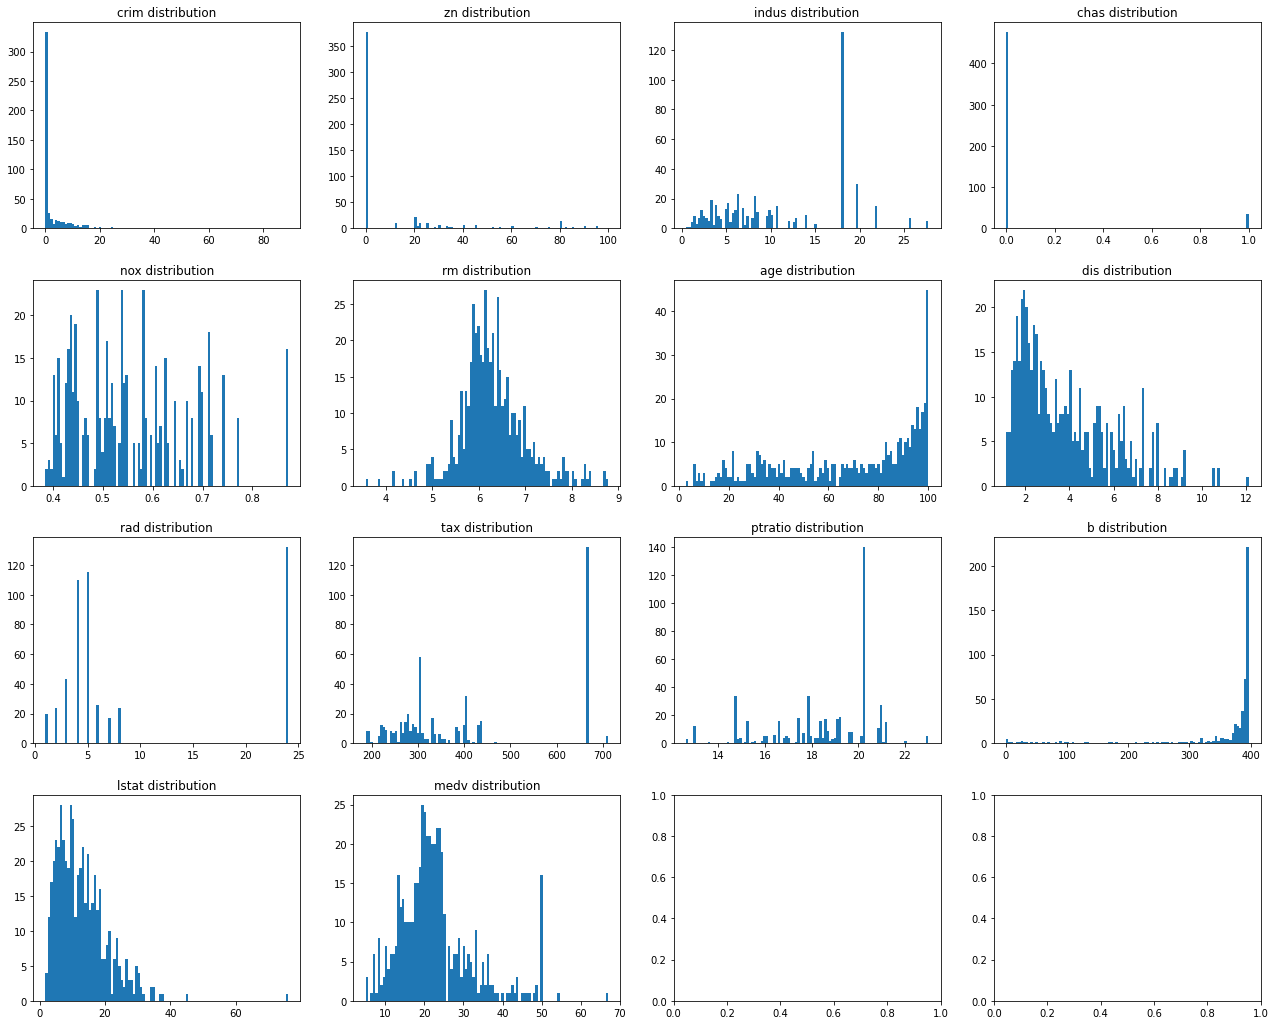

In [84]:
# строим распределения значений для всех колонок
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(22,18))
fig.subplots_adjust(hspace=0.25)

for ax, col in zip(axes.flatten(), all_data.columns):
    ax.hist(all_data[[col]].values, bins=100)
    ax.set(title=str(col).lower() + " distribution")

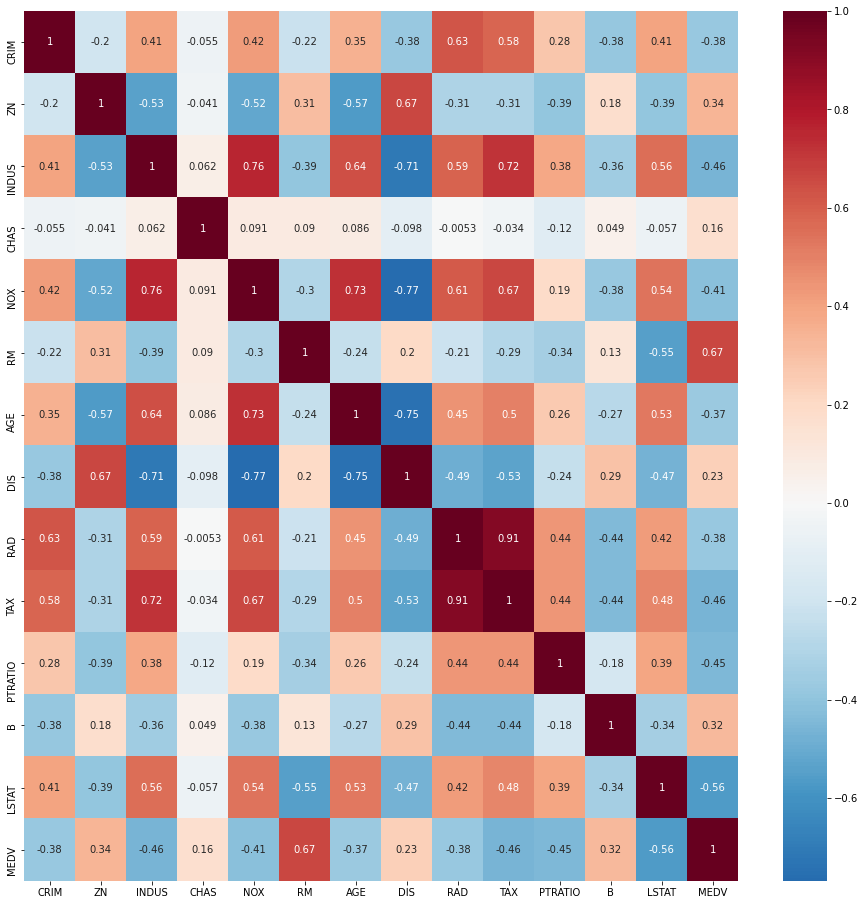

In [97]:
# строим матрицу корреляционных зависимостей между различными полями
s_fig, s_ax = plt.subplots(figsize=(16, 16))

cols = all_data.columns
sns.heatmap(all_data[cols].corr(), ax=s_ax, cmap='RdBu_r', annot=True, center=0.0)

В первой строке матрице можно увидеть корреляцию между уровнем преступности и всеми остальными параметрами

Можно увидеть, что уровень преступности практически не зависит, граничит ли собственность с рекой (CHAS)

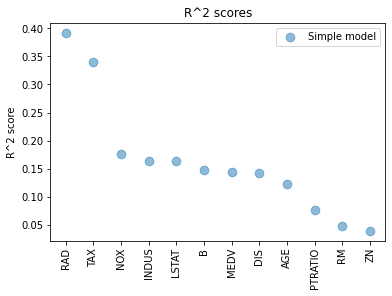

In [99]:
# найдем коэффициенты детерминации R^2 для моделей, обученных на отдельных колонках, для определения CRIM
lr = LinearRegression()
linMod = []

for col in all_df.columns.drop(['CHAS']):
    # модель линейной регрессии
    X = all_df[col].values
    lr.fit(X[:,np.newaxis],all_y)
    score_s=lr.score(X[:,np.newaxis], all_y)
    
    linMod.append({
        'simple': score_s
    })
    
linMod = pd.DataFrame(linMod)
linMod['features'] = all_df.columns.drop(['CHAS'])
linMod.sort_values(by='simple', ascending=False, inplace=True)

plt.scatter(np.arange(linMod.shape[0]), linMod['simple'], color='C0', alpha =0.5, s=75, label='Simple model')
plt.xticks(np.arange(linMod.shape[0]), linMod['features'], rotation=90)
plt.ylabel('R^2 score')
plt.legend()
plt.title('R^2 scores')
plt.show()

Как мы видим наибольшая зависимость прослеживается между CRIM и полями RAD (индекс доступности радиальных магистралей) и TAX (полная ставка налога на имущество за 10 000 долларов США)

Наименьшее влияние на CRIM оказывают ZN (доля коммерческой собственности), PTRARIO (количество учеников на одного учителя) и RM (среднее количество комнат в доме)

# Тренировка линейных моделей

In [102]:
# обнуляем мат ожидание выборки, приводим дисперсию к единице
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df)
y_scaled = scaler.fit_transform(pd.DataFrame(y_train))
X_test_scaled = scaler.fit_transform(test_df)
y_test_scaled = scaler.fit_transform(pd.DataFrame(y_test))

X_all_scaled = scaler.fit_transform(all_df)
y_all_scaled = scaler.fit_transform(pd.DataFrame(all_y))

In [103]:
linreg = LinearRegression() # создаём модель линейной регрессии
linreg.fit(X_scaled, y_scaled) # обучаем модель, используя тренировочную выборку
linreg_predictions=linreg.predict(X_test_scaled) # получаем предсказания по тестовой выборке
mse_linreg = MSE(y_test_scaled, linreg_predictions) # находим среднюю квадратичную ошибку по тестовой выборке
r2_linreg = R2(y_all_scaled, linreg.predict(X_all_scaled)) # находим коэф. детерминации по всей выборке
print('MSE Linear Regression: {:.6f}'.format(mse_linreg))
print('R2 Linear Regression: {:.6f}'.format(r2_linreg))

MSE Linear Regression: 0.577797
R2 Linear Regression: 0.447471


In [105]:
ridge = Ridge(alpha=19) # создаём ridge модель, гиперпараметр подбирался вручную
ridge.fit(X_scaled, y_scaled) # обучаем модель, используя тренировочную выборку
ridge_predictions = ridge.predict(X_test_scaled)  # получаем предсказания по тестовой выборке
mse_ridge = MSE(y_test_scaled, ridge_predictions) # находим среднюю квадратичную ошибку по тестовой выборке
r2_ridge = R2(y_all_scaled, ridge.predict(X_all_scaled)) # находим коэф. детерминации по всей выборке
print('MSE Ridge Regression: {:.6f}'.format(mse_ridge))
print('R2 Ridge Regression: {:.6f}'.format(r2_ridge))

MSE Ridge Regression: 0.575911
R2 Ridge Regression: 0.445284


# Заключение и результаты

В результате проведенного разведочного анализа данных были сделаны выводы:

* Уровень преступности (CRIM) практически не зависит, граничит ли собственность с рекой (CHAS)
* Наибольшая зависимость прослеживается между CRIM и полями RAD (индекс доступности радиальных магистралей) и TAX (полная ставка налога на имущество за 10 000 долларов США)
* Наименьшее влияние на CRIM оказывают ZN (доля коммерческой собственности), PTRARIO (количество учеников на одного учителя) и RM (среднее количество комнат в доме)

В целом прослеживались прямые и обратные линейные зависимости между параметрами и уровнем преступности. Максимальный коэффициент детерминации наблюдался у модели линейной регрессии с параметром  RAD (индекс доступности радиальных магистралей) - 0.39. Было принято решение построить две модели, задействующие все параметры:

* Модель линейной регрессии
* Ridge модель (регрессия с использованием метода регуляризации Тихонова)

Оценить их коэффициенты детерминации на всей выборке и средние квадратичные ошибки на тестовой выборке и сравнить между собой. 

При построении Ridge модели осуществлялся ручной подбор гиперпараметра альфа с целью получить минимум по MSE. В итоге альфа = 19. 

Полученные итоговые результаты:

MSE Linear Regression: 0.577797

MSE Ridge Regression: 0.575911


---


R2 Linear Regression: 0.447471

R2 Ridge Regression: 0.445284

Ridge модель незначительно превосходит модель линейной регрессии по ошибке ну уступает по коэффициенту детерминации. При этом обе модели смогли превзойти линейную регрессию с одним параметром RAD по коэффициенту детерминации приблизительно на 13%
